# This is the implementation of the new code for the 2024 April 8 Eclipse

### importing of libraries

In [1]:
import os
import numpy as np
from numpy import ma
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.dates as mdates

from datetime import datetime 
from IPython.display import Audio, display, clear_output
import scipy
from scipy import signal
from scipy.io import wavfile
import pandas as pd
from pydub import AudioSegment
import taglib
# import eclipse_calc
import cartopy.crs as ccrs
import datetime

%matplotlib inline

c:\Users\alexp\anaconda3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# Sets default style and font parameters for the plots we are making.
mpl.rcParams['font.size']      = 16
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = (12,9)
mpl.rcParams['axes.xmargin']   = 0
mpl.rcParams['axes.ymargin']   = 0.1

### This function is designed to load a wav file, and optionally normalizes the audio signal, computes a time vector, and then returns the pandas dataframe which containes the time indexed data (the signal with respect to time) and the sampling frequency. 

In [3]:
def load_wav(fname,normalize=True):
    # Load WAV file.
    fs,x0 = wavfile.read(fname)
    
    if normalize:
        x0   = x0/float(np.max(np.abs(x0)))

    # Compute time vector.
    N  = len(x0)             # Number of samples in signal
    k  = np.arange(len(x0))  # Integer time vector
    Ts = 1/fs                # Sampling Period
    t  = k*Ts
    
    df = pd.DataFrame({'time':t,'x':x0})
    df = df.set_index('time')
    
    return df, fs  

## Copying of all the processing functions

In [4]:
def process(filepath):
    x0,fs  = load_wav(filepath)
    
    # Square the signal.
    x1  = x0**2

    # Compute envelope using a rolling max function.
    Tc  = 1.2e-3 # Rolling Max Window [seconds]
    env = x1.rolling(int(Tc*fs),center=True).max()
    env = env.dropna() # Drop NaNs
    
    wp    = 250
    ws    = 1.1*wp

    gpass =  3 # The maximum loss in the passband (dB).
    gstop = 40 # The minimum attenuation in the stopband (dB).
    
    N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
    sos   = signal.butter(N, Wn, 'low', fs=fs, output='sos')

    env_1      = env.copy()
    env_1['x'] = signal.sosfiltfilt(sos,env['x'])

    wp    = 10
    ws    = 0.8*wp

    gpass =  3 # The maximum loss in the passband (dB).
    gstop = 40 # The minimum attenuation in the stopband (dB).

    N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
    sos   = signal.butter(N, Wn, 'high', fs=fs, output='sos')

    env_2      = env_1.copy()
    env_2['x'] = signal.sosfiltfilt(sos,env_1['x'])
    
    return env_2, signal.sosfiltfilt(sos,env_1['x']), fs

### Function that allows us to find the beat notes which is the maximum frequency

In [5]:
def find_max(X,freq,minfreq,maxfreq):
    if maxfreq==0:
        maxfreq=10000
    start = np.argwhere(freq>=minfreq)[0][0]
    end = np.argwhere(freq<=maxfreq)[-1:][0][0]
    maxima = max(X[start:end])
    maximum = np.argwhere(X==maxima)
    maximum = abs(freq[maximum][0])
    return maximum

In [6]:
def find_maxes(X, freq, minfreq, maxfreq, threshold):
    maxima_freqs = []
    if maxfreq == 0:
        maxfreq = 10000
    start = np.argwhere(freq >= minfreq)[0][0]
    end = np.argwhere(freq <= maxfreq)[-1:][0][0]
    maxima_indices = np.argwhere(X[start:end] >= threshold).flatten()
    maxima_freqs = freq[start:end][maxima_indices]
    return maxima_freqs


### Plotting of the new signal

In [7]:
def new_plot_sig(df,column='x',title=None,tlim=None,flim=None,
                 plot_fft=False, peaktime='', minfreq=0,maxfreq=10000):
   
    x    = df[column]
    tvec = df.index
    Ts   = tvec[1] - tvec[0]
    Fs   =1/Ts

    if tlim is None:
        tlim = (0,np.max(tvec))
    elif tlim is not None:
        tf  = np.logical_and(tvec >= tlim[0],
                                tvec <  tlim[1])
        xt  = x[tf].copy()
        
    han_win = np.hanning(len(xt))
    x_han   = han_win*xt
    nfft    = len(x_han)
    if nfft < 2**16: 
        nfft = 2**16

    X_psd   = np.abs(np.fft.fftshift(np.fft.fft(x_han,n=nfft)*Ts*2))**2
    f       = np.fft.fftshift(np.fft.fftfreq(nfft,Ts))

    if plot_fft==True:
        if maxfreq==0:
            maxfreq=10000
        flim = (0,maxfreq)
        start = np.argwhere(f>=minfreq)[0][0]
        end = np.argwhere(f<=maxfreq)[-1:][0][0]

        maxima = max(X_psd[start:end])
        maximum = np.argwhere(X_psd==maxima)
        maximum = abs(f[maximum][0])
        peaktime=str(peaktime[0])+'_'+str(peaktime[1]+1)

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(2,1,1)
        bx = fig.add_subplot(2,1,2)
        bx.plot(tvec,x)
        bx.set_xlim(tlim)

        ax.plot(f,X_psd)
        ax.plot([maximum,maximum],[0,max(X_psd)],linewidth=2)
        ax.plot([minfreq,minfreq],[0,max(X_psd)],linewidth=3, color='black')

        ax.plot([0,maximum[0]],[max(X_psd),max(X_psd)],linewidth=2, color='red')
        ax.plot([0,maximum[0]],[maxima,maxima],linewidth=2, color='green')

        ax.scatter(maximum,maxima,linewidths=5,label=str(maximum[0])[:5]+" Hz",color='green')
        
        ax.scatter(f[signal.find_peaks(X_psd)[0]],X_psd[signal.find_peaks(X_psd)[0]], color='black')
        ####################################
        local_maxes_x = f[signal.find_peaks(X_psd)[0]]
        local_maxes_y  =X_psd[signal.find_peaks(X_psd)[0]]
        # print(local_maxes_x)
        # print(local_maxes_y)
        local_maxes = pd.DataFrame({'x':local_maxes_x,'y':local_maxes_y})
        filtered_maxes = local_maxes.query('x>=0').query('y>=.00001')
        
        
        
        ##################################
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('PSD')
        ax.set_xlim(flim)
        # ax.set_title(title[:-4]+'_'+peaktime)
        # ax.set_yticklabels('')
        ax.legend()

        ax2 = ax.twiny()
        ax2.xaxis.set_ticks_position("bottom")
        ax2.xaxis.set_label_position("bottom")
        ax2.spines["bottom"].set_position(("axes", -0.15))
        ax2.set_frame_on(True)
        ax2.patch.set_visible(False)
        newlabels = np.arange(0,flim[1]+1,flim[1]/12)
        ax2.set_xticks(np.arange(0,len(newlabels)))
        ax2.set_xticklabels(newlabels/minfreq)
        ax2.ticklabel_format()
        ax2.set_xlabel('TDOA [ms]')
        
        # ax3 = ax.twiny()
        # ax3.xaxis.set_ticks_position("bottom")
        # ax3.xaxis.set_label_position("bottom")
        # ax3.spines["bottom"].set_position(("axes", -0.3))
        # ax3.set_frame_on(True)
        # ax3.patch.set_visible(False)
        # newlabels = np.arange(0,flim[1]+1,flim[1]/10)
        # ax3.set_xticks(np.arange(0,len(newlabels)))
        # ax3.set_xticklabels((300/2)*newlabels/minfreq)
        # ax3.ticklabel_format()
        # ax3.set_xlabel('Layer Height [km]')


        plt.tight_layout()
        clear_output(wait=True)
        plt.show()
        # fig.savefig('fft_plots\\'+title[:-4]+'_'+peaktime+'.png',bbox_inches='tight')
        plt.close(fig)

    return X_psd, f

### The find starting point function allows us to auto-correlate a clean non-QRM'd file and enables us to find the starting points of the first chirp in a wave file *****CHANGE*******

In [8]:
def find_starting_points(sample,wav_list,plot_start):
    starting_times = []
    for fpath in wav_list:
        wav_env_x,wav_fs = load_wav(fpath)
        print(wav_fs)
        wav_env_x=wav_env_x['x']
        correlation = signal.correlate(wav_env_x,sample,mode='same')

        
        corrmax = (np.argwhere(correlation==max(correlation[0:len(correlation)//2])))
        corrmax = (corrmax[0][0])/wav_fs
        starting_times.append(corrmax)
        if plot_start == True:
            tlim = (corrmax -3, corrmax + 5)
            tau = np.arange(len(wav_env_x))*(1/wav_fs)

            fig = plt.figure(figsize=(15,8))
            ax = fig.add_subplot(3,1,1)
            xx = np.arange(len(sample))*(1/wav_fs)#sampe singal fs
            ax.plot(xx,sample)
            # ax.plot([corrmax,corrmax],[-.5,.5])
            # ax.set_xlim([0,0.01])
            ax.set_title("Sample")
            ax.set_xlabel("time [seconds]")
            
            ax = fig.add_subplot(3,1,2)
            ax.plot(tau,wav_env_x)
            ax.plot([corrmax,corrmax],[-.5,.5])
            ax.set_xlim(tlim)
            ax.set_title(fpath)
            
            ax = fig.add_subplot(3,1,3)
            ax.plot(tau,correlation)
            # ax.plot([corrmax,corrmax],[-.5,.5])
            ax.axvline(corrmax, color = 'yellow')
            # ax.set_xlim(tlim)
            ax.set_title(fpath)
        
            fig.tight_layout()
            clear_output(wait=True)
            plt.show()
            # fig.savefig('start_time_plots\\'+fpath[:-4]+'.png',bbox_inches='tight')
            plt.close(fig)
            # break
    return starting_times

In [9]:
def find_ending_points(sample,wav_list,plot_start):
    starting_timesv2 = []
    
    for fpath in wav_list:
        wav_env_x,wav_fs = load_wav(fpath)
        print(wav_fs)
        wav_env_x=wav_env_x['x']
        correlation = signal.correlate(wav_env_x,sample,mode='same')

        
        corrmax = (np.argwhere(correlation==max(correlation[len(correlation)//2:-2*wav_fs])))
        corrmax = (corrmax[0][0])/wav_fs
        starting_timesv2.append(corrmax)
        
        if plot_start == True:
            tlim = (corrmax -3, corrmax + 5)
            tau = np.arange(len(wav_env_x))*(1/wav_fs)

            fig = plt.figure(figsize=(15,8))
            ax = fig.add_subplot(3,1,1)
            xx = np.arange(len(sample))*(1/wav_fs)#sampe singal fs
            ax.plot(xx,sample)
            # ax.plot([corrmax,corrmax],[-.5,.5])
            # ax.set_xlim([0,0.01])
            ax.set_title("Sample")
            ax.set_xlabel("time [seconds]")
            
            ax = fig.add_subplot(3,1,2)
            ax.plot(tau,wav_env_x)
            ax.plot([corrmax,corrmax],[-.5,.5])
            ax.set_xlim(tlim)
            ax.set_title(fpath)
            
            ax = fig.add_subplot(3,1,3)
            ax.plot(tau,correlation)
            # ax.plot([corrmax,corrmax],[-.5,.5])
            ax.axvline(corrmax, color = 'yellow')
            # ax.set_xlim(tlim)
            ax.set_title(fpath)
        
            fig.tight_layout()
            clear_output(wait=True)
            plt.show()
            # fig.savefig('start_time_plots\\'+fpath[:-4]+'.png',bbox_inches='tight')
            plt.close(fig)
            # break
    return starting_timesv2

### The find_beat_notes method now needs to change, we only have one set of sweep rate now, so I kept the processing of the previous code while only considering the change in the for loop. Peaks is now one array, maxes is also one array. 

In [10]:
def find_scatter_notes(data_set,wav_list,starting_times,range_gates,plot_fft):
    all_beats = []
    for file_num,fpath in enumerate(wav_list):
        # fpath = wavlist[file_num]
        # fpath = wav_list[i]
    ##What Im trying to do is basically create new processing functions which I suspect will be needed
        if data_set == '20m':
            wav_env,wav_env_x,wav_fs = process(fpath)
        
        elif data_set == '40m':
            wav_env,wav_env_x,wav_fs = process(fpath)
        elif data_set == '60m':
            wav_env,wav_env_x,wav_fs = process(fpath)
###########################################################################
        peaks1 = []
        peaks2 = []
        for i in range(0,5):
            peaks1.append(starting_times[file_num]+.245*i)
            peaks2.append(starting_times[file_num]+.245*4 + 0.6 + .245*i)
        
        peaks = np.array([peaks1,peaks2])
        peaks=peaks.flatten()
        ##creating a new array but instead of 5, we only need one array for one sweep rate
        maxes= []
        ###the change here is we are only using 10 Hz/ms so we must now adjust
        ''' '''
        ''' '''
        # print(peaks)
        ### This needs to change
        for peak_num,peak in enumerate(peaks):
            tlim = (peak+range_gates[0],peak+range_gates[1])
            minfreq=range_gates[2]
            maxfreq=range_gates[3]
            X, freq = new_plot_sig(wav_env,title=fpath,tlim=tlim,
                                   peaktime=[5,peak_num], 
                                   plot_fft=plot_fft,
                                   minfreq = minfreq,maxfreq = maxfreq)
            maximum = find_maxes(X,freq,minfreq,maxfreq, threshold = 10)
            maxes.append(maximum)
            
        all_beats.append(np.array(maxes).flatten())
    return np.array(all_beats)
    

In [11]:
def find_beat_notes(data_set,wav_list,starting_times,range_gates,plot_fft):
    all_beats = []
    for file_num,fpath in enumerate(wav_list):
        # fpath = wavlist[file_num]
        # fpath = wav_list[i]
    ##What Im trying to do is basically create new processing functions which I suspect will be needed
        wav_env, wav_env_x, wav_fs = process(fpath)  
#########################################################################
        peaks1 = []
        peaks2 = []
        peaks3 = []
        peaks4 = []
        for i in range(0,5):
            peaks1.append(starting_times[file_num]+.245*i + 1.9)   ##we determined the spacing between the chirps was 1.9
            peaks2.append(starting_times[file_num]+.245*4 + 0.6 + .245*i + 1.9)
            peaks3.append(starting_times[file_num] + range_gates[4] + 0.75*i)
            peaks4.append(starting_times[file_num] + range_gates[4] + 0.75*4 + (0.75*i) + 1.111)
        
        peaks = np.array([peaks3,peaks4]) ###added peaks3 maybe that makes a difference
        peaks=peaks.flatten() ##flatten the peaks
        ##creating a new array but instead of 5, we only need one array for one sweep rate
        maxes= []
        ###the change here is we are only using 10 Hz/ms so we must now adjust
        ''' '''
        ''' '''
        # print(peaks)
        ### This needs to change
        for peak_num,peak in enumerate(peaks): 
            tlim = (peak+range_gates[0],peak+range_gates[1])
            minfreq=range_gates[2]
            maxfreq=range_gates[3]
            ##### fft maxes
            X, freq = new_plot_sig(wav_env,title=fpath,tlim=tlim,
                                   peaktime=[5,peak_num], 
                                   plot_fft=plot_fft,
                                   minfreq = minfreq,maxfreq = maxfreq)
            maximum = find_max(X,freq,minfreq,maxfreq)
            maxes.append(maximum)
            print(fpath, end = "\r")
        all_beats.append(np.array(maxes).flatten())
    return np.array(all_beats)

### export and save each band into its respective array
### This is where we select the sample 

In [12]:
# directories = {
#     '20m': '20M_TX-N5DUP_RX-KD2NQV_2236km',
#     '40m': '40M_TX-WA5FRF_RX-N5DUP_318km',
#     '60m': '60M_TX-WA5FRF_RX-N5DUP_318km',
#     'scranton': '20M_TX-N5DUP_RX-W3USR_2236km',
#     '40mSam': '40mAB5YO',
#     '60mSam': '60mAB5YO'
# }

### Create new arrays that will house the different .wav list directories
wavlist_20m = []
wavlist_40m = []
wavlist_60m = []
wavlist_scranton = []
wavlist_40mSam = []
wavlist_60mSam = []
wavlist_40mN6RFM5 = []
wavlist_new_chirp = []
wavlist_AG = []

directory_20m = '20M_TX-N5DUP_RX-KD2NQV_2236km'
directory_40m = '40M_TX-WA5FRF_RX-N5DUP_318km'
directory_60m = '60M_TX-WA5FRF_RX-N5DUP_318km'
directory_scranton = '20M_TX-N5DUP_RX-W3USR_2236km'
directory_40mSam ='40mAB5YO'
directory_60mSam = '60mAB5YO'
directory_40mN6RFM5 = 'N6RFM5 TDOA Experiment 8April24'
directory_new_chirp = 'new_chirp_folder'
directory_AG = 'AG5HR'
###loop to now analyze the wav files in each directory

for filename in os.listdir(directory_20m):
    f= os.path.join(directory_20m, filename)
    if os.path.isfile(f):
        wavlist_20m.append(f)  

for filename in os.listdir(directory_40m):
    f= os.path.join(directory_40m, filename)
    if os.path.isfile(f):
        wavlist_40m.append(f)

for filename in os.listdir(directory_60m):
    f= os.path.join(directory_60m, filename)
    if os.path.isfile(f):
        wavlist_60m.append(f)
        
for filename in os.listdir(directory_scranton):
    f= os.path.join(directory_scranton, filename)
    if os.path.isfile(f):
        wavlist_scranton.append(f) 

for filename in os.listdir(directory_40mSam):
    f= os.path.join(directory_40mSam, filename)
    if os.path.isfile(f):
        wavlist_40mSam.append(f)

for filename in os.listdir(directory_60mSam):
    f= os.path.join(directory_60mSam, filename)
    if os.path.isfile(f):
        wavlist_60mSam.append(f)

for filename in os.listdir(directory_40mN6RFM5):
    f= os.path.join(directory_40mN6RFM5, filename)
    if os.path.isfile(f):
        wavlist_40mN6RFM5.append(f)

# for filename in os.listdir(directory_new_chirp):
#     f= os.path.join(directory_new_chirp, filename)
#     if os.path.isfile(f):
#         wavlist_new_chirp.append(f)

# for filename in os.listdir(directory_AG):
#     f= os.path.join(directory_AG, filename)
#     if os.path.isfile(f):
#         wavlist_AG.append(f)
    
        
#we now look for wave files and export them into this program

for wavefile in wavlist_20m:
    path  = wavefile
    sound = AudioSegment.from_wav(path)
    sound = sound.set_channels(1)
    sound.export(path, format="wav")
    
for wavefile in wavlist_40m:
    path  = wavefile
    sound = AudioSegment.from_wav(path)
    sound = sound.set_channels(1)
    sound.export(path, format="wav")

for wavefile in wavlist_60m:
    path  = wavefile
    sound = AudioSegment.from_wav(path)
    sound = sound.set_channels(1)
    sound.export(path, format="wav")

for wavefile in wavlist_scranton:
    path  = wavefile
    sound = AudioSegment.from_wav(path)
    sound = sound.set_channels(1)
    sound.export(path, format="wav")
    
for wavefile in wavlist_40mSam:
    path  = wavefile
    sound = AudioSegment.from_wav(path)
    sound = sound.set_channels(1)
    sound.export(path, format="wav")

for wavefile in wavlist_60mSam:
    path  = wavefile
    sound = AudioSegment.from_wav(path)
    sound = sound.set_channels(1)
    sound.export(path, format="wav")

for wavefile in wavlist_40mN6RFM5:
    path = wavefile
    sound = AudioSegment.from_wav(path)
    sound = sound.set_channels(1)
    sound.export(path, format = "wav")
    
# for wavefile in wavlist_new_chirp:
#     path  = wavefile
#     sound = AudioSegment.from_wav(path)
#     sound = sound.set_channels(1)
#     sound.export(path, format="wav")

# for wavefile in wavlist_AG:
#     path  = wavefile
#     sound = AudioSegment.from_wav(path)
#     sound = sound.set_channels(1)
#     sound.export(path, format="wav")
    
'''"Chirp Analysis.ipynb"
## Correlation using PN burst
# sample_path  = os.path.join('samples','Correlation')
# sample_env_x,sample_fs = load_wav(sample_path+'.wav')
# sample_env_x=sample_env_x['x']
# sample_20m = sample_env_x

# sample_path  = os.path.join('samples','Correlation')
# sample_env,sample_env_x,sample_fs = process(sample_path + '.wav')
# sample_40m = sample_env_x

# sample_path  = os.path.join('samples','Correlation')
# sample_env,sample_env_x,sample_fs = process(sample_path + '.wav')
# sample_60m = sample_env_x

# sample_path  = os.path.join('samples','Correlation')
# sample_env,sample_env_x,sample_fs = process(sample_path + '.wav')
# sample_scranton = sample_env_x
'''
#Correlation using the 1 kHz tone

# sample_path  = os.path.join('samples','Correlation20m')
# sample_env_x,sample_fs = load_wav(sample_path+'.wav')
# sample_env_x=sample_env_x['x']
# sample_20m = sample_env_x

sample_path  = os.path.join('samples','Correlation20m')
sample_env_x,sample_fs = load_wav(sample_path+'.wav')
sample_env_x=sample_env_x['x']
sample_20m = sample_env_x

sample_path  = os.path.join('samples','CorrelationV7')
sample_env_x,sample_fs = load_wav(sample_path+'.wav')
sample_env_x=sample_env_x['x']
sample_40m = sample_env_x

sample_path  = os.path.join('samples','CorrelationV8')
sample_env_x,sample_fs = load_wav(sample_path+'.wav')
sample_env_x=sample_env_x['x']
sample_60m = sample_env_x

sample_path  = os.path.join('samples','Correlation20m')
sample_env_x,sample_fs = load_wav(sample_path+'.wav')
sample_env_x=sample_env_x['x']
sample_scranton = sample_env_x

sample_path  = os.path.join('samples','CorrelationV7')
sample_env_x,sample_fs = load_wav(sample_path+'.wav')
sample_env_x=sample_env_x['x']
sample_40mSam = sample_env_x

sample_path  = os.path.join('samples','CorrelationV8')
sample_env_x,sample_fs = load_wav(sample_path+'.wav')
sample_env_x=sample_env_x['x']
sample_60mSam = sample_env_x

sample_path  = os.path.join('samples','1-cycles')
sample_env_x,sample_fs = load_wav(sample_path+'.wav')
sample_env_x=sample_env_x['x']
sample_40mN6RFM5 = sample_env_x

sample_path  = os.path.join('samples','BW wide PN')
sample_env_x,sample_fs = load_wav(sample_path+'.wav')
sample_env_x=sample_env_x['x']

sample_path  = os.path.join('samples','Correlation_AG')
sample_env_x,sample_fs = load_wav(sample_path+'.wav')
sample_AG = sample_env_x['x']



sample_new_chirp = sample_env_x
sample_new_chirp_fs = sample_fs

# print(sample_60mSam)
print(sample_AG)

## Correlation using the initial 15/10 sweep rates
# sample_path  = os.path.join('samples','CorrelationV3')
# sample_env_x,sample_fs = load_wav(sample_path+'.wav')
# sample_env_x=sample_env_x['x']
# sample_20m = sample_env_x

# sample_path  = os.path.join('samples','CorrelationV3')
# sample_env,sample_env_x,sample_fs = process(sample_path + '.wav')
# sample_40m = sample_env_x

# sample_path  = os.path.join('samples','CorrelationV3')
# sample_env,sample_env_x,sample_fs = process(sample_path + '.wav')
# sample_60m = sample_env_x

# sample_path  = os.path.join('samples','CorrelationV3')
# sample_env,sample_env_x,sample_fs = process(sample_path + '.wav')
# sample_scranton = sample_env_x

# plt.plot(wavfile.read(sample_path)[1]/10000)
# plt.plot(sample_20m)
# plt.plot(sample_40m)
# plt.plot(sample_60m) 
# plt.plot(sample_scranton)
# plt.plot(sample_40mSam)
# plt.plot(sample_AG)

time
0.000000   -0.014324
0.000125   -0.009899
0.000250   -0.014382
0.000375   -0.033714
0.000500    0.010656
              ...   
2.347375    0.004018
2.347500   -0.020030
2.347625   -0.008094
2.347750    0.009375
2.347875   -0.024805
Name: x, Length: 18784, dtype: float64


C:\Users\alexp\AppData\Local\Temp\ipykernel_17064\515702126.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs,x0 = wavfile.read(fname)


In [13]:
start_sec = 4
end_sec = 5

start_index = int(start_sec * sample_new_chirp_fs)
end_index = int(end_sec * sample_new_chirp_fs)

In [14]:
year = 2024
month = 4
day = 8

twentyBand = []
fortyBand = []
sixtyBand = []
scrantonBand=[]
fortymSamBand = []
sixtymSamBand =[]
N6RFM5band = []
newchirpband = []
AG5Band = []

twentyBand_times = []
fortyBand_times = []
sixtyBand_times = []
scrantonBand_times=[]
fortymSamBand_times = []
sixtymSamBand_times = []
N6RFM5band_times = []
newchirpbandtimes = []
AG5Band_times = []

for i, file in enumerate(os.listdir('20M_TX-N5DUP_RX-KD2NQV_2236km')):
    band = file[4:10]   ###index of where the stuff is
    # print(band)
    if band =='EM02CH': 
        hour = int(file[18:20])
        minute = int(file[20:22])
        # print(hour,minute)
        twentyBand.append(i)
        twentyBand_times.append(datetime.datetime(year,month,day,hour,minute))

print(twentyBand_times)

for i, file in enumerate(os.listdir('40M_TX-WA5FRF_RX-N5DUP_318km')):
    band = file[4:10]   ###index of where the stuff is
    if band =='EL09nn': 
        hour = int(file[18:20])
        minute = int(file[20:22])
        # print(hour,minute)
        fortyBand.append(i)
        fortyBand_times.append(datetime.datetime(year,month,day,hour,minute))

print(fortyBand_times)

for i, file in enumerate(os.listdir('60M_TX-WA5FRF_RX-N5DUP_318km')):
    band = file[4:10]   ###index of where the stuff is
    if band =='EL09nn': 
        hour = int(file[18:20])
        minute = int(file[20:22])
        # print(hour,minute)
        sixtyBand.append(i)
        sixtyBand_times.append(datetime.datetime(year,month,day,hour,minute))

print(sixtyBand_times)

for i, file in enumerate(os.listdir('20M_TX-N5DUP_RX-W3USR_2236km')):
    band = file[0:4]   ###index of where the stuff is
    if band =='2024': 
        hour = int(file[9:11])
        minute = int(file[11:13])
        # print(hour,minute)
        scrantonBand.append(i)
        scrantonBand_times.append(datetime.datetime(year,month,day,hour,minute))

print(scrantonBand_times)

for i, file in enumerate(os.listdir('40mAB5YO')):
    band = file[0:4]   ###index of where the stuff is
    if band =='2404': 
        hour = int(file[7:9])
        minute = int(file[9:11])
        # print(hour,minute)
        fortymSamBand.append(i)
        fortymSamBand_times.append(datetime.datetime(year,month,day,hour,minute))

print(fortymSamBand_times)

for i, file in enumerate(os.listdir('60mAB5YO')):
    band = file[0:4]   ###index of where the stuff is
    if band =='2404': 
        hour = int(file[7:9])
        minute = int(file[9:11])
        # print(hour,minute)
        sixtymSamBand.append(i)
        sixtymSamBand_times.append(datetime.datetime(year,month,day,hour,minute))

for i, file in enumerate(os.listdir('N6COPY')):
    band = file[4:8]   ###index of where the stuff is
    if band =='EM12': 
        hour = int(file[11:13])
        minute = int(file[13:15])
        # print(hour,minute)
        N6RFM5band.append(i)
        N6RFM5band_times.append(datetime.datetime(year,month,day,hour,minute))

# for i, file in enumerate(os.listdir('new_chirp_folder')):
#     band = file[0:4]   ###index of where the stuff is
#     if band =='2024': 
#         hour = int(file[11:13])
#         minute = int(file[13:15])
#         # print(hour,minute)
#         newchirpband.append(i)
#         newchirpbandtimes.append(datetime.datetime(year,month,day,hour,minute))
        
# for i, file in enumerate(os.listdir('AG5HR')):
#     band = file[0:4]   ###index of where the stuff is
#     if band =='2024': 
#         hour = int(file[9:11])
#         minute = int(file[11:13]) 
#         # print(hour,minute)
#         AG5Band.append(i)
#         AG5Band_times.append(datetime.datetime(year,month,day,hour,minute))

# print(AG5Band_times)


[datetime.datetime(2024, 4, 8, 16, 0), datetime.datetime(2024, 4, 8, 16, 10), datetime.datetime(2024, 4, 8, 16, 20), datetime.datetime(2024, 4, 8, 16, 30), datetime.datetime(2024, 4, 8, 16, 50), datetime.datetime(2024, 4, 8, 17, 0), datetime.datetime(2024, 4, 8, 17, 10), datetime.datetime(2024, 4, 8, 17, 20), datetime.datetime(2024, 4, 8, 17, 30), datetime.datetime(2024, 4, 8, 17, 40), datetime.datetime(2024, 4, 8, 17, 50), datetime.datetime(2024, 4, 8, 18, 0), datetime.datetime(2024, 4, 8, 18, 10), datetime.datetime(2024, 4, 8, 18, 30), datetime.datetime(2024, 4, 8, 18, 40), datetime.datetime(2024, 4, 8, 18, 40), datetime.datetime(2024, 4, 8, 18, 40), datetime.datetime(2024, 4, 8, 18, 50), datetime.datetime(2024, 4, 8, 18, 50), datetime.datetime(2024, 4, 8, 18, 50), datetime.datetime(2024, 4, 8, 19, 10), datetime.datetime(2024, 4, 8, 19, 30), datetime.datetime(2024, 4, 8, 19, 40), datetime.datetime(2024, 4, 8, 19, 50), datetime.datetime(2024, 4, 8, 20, 0)]
[datetime.datetime(2024, 4, 

### Okay it is time to start the analysis, lets find the starting points

In [15]:
# start_times_20 = find_ending_points(sample_20m,wavlist_20m,plot_start=True)
# start_times_40 = find_starting_points(sample_40m[0.3:0.4],wavlist_40m,plot_start=False)
# start_times_60 = find_starting_points(sample_60m[0.3:0.4],wavlist_60m,plot_start=False)
# start_times_scranton = find_starting_points(sample_20m, wavlist_scranton, plot_start= False)
# start_times_Sam40 = find_starting_points(sample_40mSam[0.3:0.4], wavlist_40mSam, plot_start= False)
# start_times_Sam60 = find_starting_points(sample_60mSam[1:1.5], wavlist_60mSam, plot_start= False)
start_times_Sam60 = find_starting_points(sample_60mSam[0.3:0.4], wavlist_60mSam, plot_start= False) 

# start_times_N6RM540 = find_starting_points(sample = sample_40mN6RFM5[1:2], wav_list = wavlist_40mN6RFM5, plot_start = True)

# start_times_new_chirp = find_starting_points(sample_new_chirp[0.3:0.35], wavlist_new_chirp, plot_start= True)

# start_times_AG = find_starting_points(sample_AG[0.5:0.8], wavlist_AG, plot_start= True)
# print(wavlist_60mSam)
# print(wavlist_AG)
# print(start_index,end_index)
# print(len(sample_new_chirp))
# sample_new_chirp = sample_new_chirp[start_index:end_index]

# print(sample_new_chirp)
# print(sample_new_chirp.values)
# start_times_new_chirp = find_starting_points(sample_new_chirp[1.80:1.86], wavlist_new_chirp, plot_start= True)


44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100
44100


### Find the beat note frequencies using range gating (we only need this for the 10 hz/ms) THE RANGE GATES NEED CHANGE

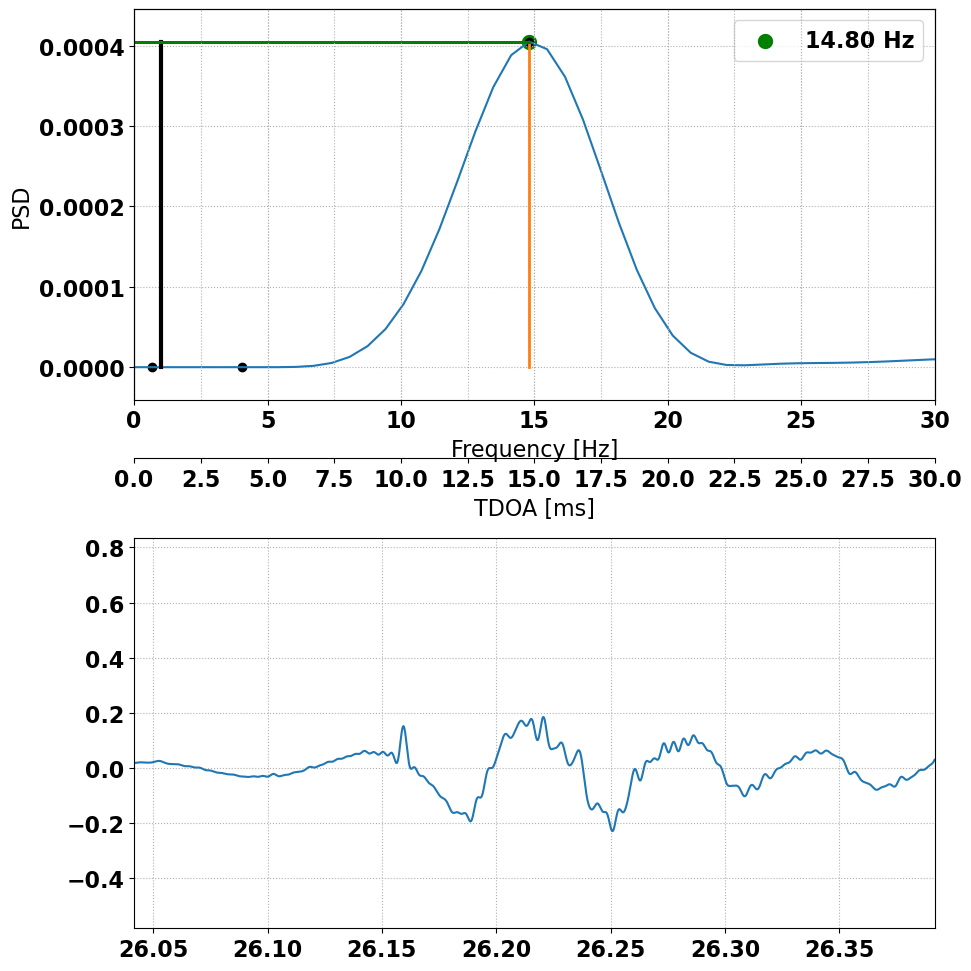

In [16]:
twentym_range_gates = [0.025,0.30,10  ,10  *2.5,-9.35]# 4.1]

fortym_range_gates = [-0.4,0.5, 10, 3*10, 4.8]

# sixtym_range_gates = [-0.2,0.2,10, 10 * 3, 4.1] ##originally 4.1, and -0.2,0.2

# sixtym_range_gates = [-0.4 + 0.27,0.4,10, 10 * 3, 4.1] ##originally 4.1, and -0.2,0.2

sixtymSam_range_gates = [-0.1,0.25,1, 10 * 3, 4.1] ##originally 4.1, and -0.2,0.2

sixtym_range_gates = [-0.4,0.4,10, 10 * 3, 4.9] ##originally 4.1, and -0.2,0.2

scranton_range_gates = [0.025,0.30,10  ,10  *2.5, 4.1]

# beats_20m = find_beat_notes('20m',wavlist_20m,start_times_20,twentym_range_gates,plot_fft= True)
# beats_40m = find_beat_notes('40m',wavlist_40m,start_times_40,fortym_range_gates,plot_fft=False)
# beats_60m = find_beat_notes('60m',wavlist_60m,start_times_60,sixtym_range_gates,plot_fft=False)
# # beats_W3USR = find_beat_notes('20m',wavlist_scranton, start_times_scranton, scranton_range_gates, plot_fft= False)

# beats_40mSam = find_beat_notes('40m',wavlist_40mSam,start_times_Sam40,fortym_range_gates,plot_fft=False)
beats_60mSam = find_beat_notes('60m',wavlist_60mSam,start_times_Sam60,sixtymSam_range_gates,plot_fft=True)
### multiply TDOA 142*TDOA + 36.2 

### What to do after the data is processed, we call the POSTprocessing

In [17]:
print(beats_60mSam/10)

[[1.68228149 1.48040771 1.54769897 1.54769897 1.61499023 1.0093689
  1.41311646 1.48040771 1.48040771 1.54769897]
 [1.88415527 1.3458252  1.81686401 1.74957275 1.61499023 1.14395142
  1.41311646 1.41311646 1.3458252  1.95144653]
 [1.27853394 1.61499023 1.61499023 1.54769897 1.48040771 1.07666016
  1.41311646 1.41311646 1.95144653 2.01873779]
 [2.89352417 1.41311646 1.88415527 1.74957275 1.68228149 1.0093689
  1.54769897 1.48040771 1.48040771 1.41311646]
 [1.21124268 1.3458252  1.3458252  1.27853394 1.48040771 1.0093689
  1.3458252  1.41311646 2.89352417 1.88415527]
 [1.27853394 1.95144653 1.88415527 1.81686401 1.68228149 1.0093689
  1.54769897 1.48040771 1.88415527 1.88415527]
 [1.27853394 1.54769897 1.48040771 1.48040771 1.48040771 1.0093689
  2.01873779 1.95144653 1.95144653 1.95144653]
 [1.27853394 1.88415527 1.81686401 1.74957275 1.74957275 1.0093689
  1.3458252  2.08602905 1.88415527 1.81686401]
 [2.89352417 1.27853394 1.95144653 1.68228149 1.48040771 1.0093689
  1.88415527 1.6822

In [18]:
##ManuallyDecodedN5DUP40m = [1.62,1.59,1.72,1.88,1.89,1.82,1.9,1.96,1.95,1.89,1.96,1.94,2.02,1.89,1.8,1.82,1.89,1.67,1.76,1.83,1.85,1.75,1.87,1.75,1.97,1.98,1.87,1.04,2.92,1,.85,1.72,1.922,1.71]
# np.nan

ManuallyDecodedN5DUP40m = [1.62, 1.59, 1.72, 1.88, 1.89, 1.82, 1.9, 1.96, 1.95, 1.89, 1.96, 1.94, 2.02, 1.89, 1.8, 1.82, 1.89, 1.67, 1.76, 1.83, 1.85, 1.75, 1.87, 1.75, 1.97, 1.98, 1.87, 2.04, 1.92, 1.85, 1.72, 1.92, 1.71]
ManuallyDecodedAB5YO40m = [1.72, 1.69, 1.80, 1.84, 1.86, 1.86, 1.94, 1.90, 1.88, 2.04, 2.04, 2.04, 2.08, 2.08, 2.02, 1.94, 1.92, 1.97, 1.97, 1.86, 1.90, 1.91, 1.90, 1.91, 1.82, 1.91, 1.84, 1.84, 1.76, 1.93, 1.97, 1.97, 1.99, 2.05, 2.01, 2.00, 1.99, 2.02, 2.02, 2.02, 2.01, 1.97, 1.96, 1.92, 1.93, 1.95, 1.91,1.90, 1.91, 1.89]
ManuallyDecodedAB5YO60m = [1.61, 1.52, 1.59, 1.54, 1.64, 1.61, 1.64, 1.67, 1.60, 1.67, 1.64, 1.72, 1.63, 1.82, 1.75, 1.65, 1.85, 2.00, 1.72, 1.80, 1.92, 1.85, 1.92, 2.00, 2.09, 1.96, 1.92, 1.85, 1.75, 1.89, 1.89, 1.89, 1.85, 1.82, 1.72, 1.65, 1.57, 1.65, 1.68, 1.77]

In [19]:
# AutoCorrelatedN5DUP40m = [1.681,1.719,1.473,np.NaN,2.030,1.879,1.719,2.106,np.NaN,1.851,1.785,2.068,1.898,1.775,np.NaN,1.719,np.NaN,1.605,1.804,np.NaN,1.870,1.860,1.917,2.002,np.NaN,2.162,np.NaN,2.068,1.936,1.974,1.964,1.700]
# AutoCorrelatedAB5YO40m = [1.700, 1.728, 1.737, 1.804, 1.785, 1.870, 1.775, 1.879, 1.841, 1.898, 2.002, 1.804, 2.040, np.NaN, 2.030, 1.945, 2.011, 1.926, 1.879, 1.926, 1.841, 1.860, 1.974, 2.077, 1.766, 1.851, 1.775, np.NaN, 1.709, np.NaN, 1.898, np.NaN, 1.813, np.NaN, np.NaN, np.NaN, 1.889, np.NaN, 1.889, np.NaN, np.NaN, 2.040, np.NaN, 1.917, np.NaN, 1.945, np.NaN, 1.785, 1.79, np.NaN
# ]
# AutoCorrelatedAB5YO60m = [1.5625, 1.635, 1.635, 1.688, 1.510, 1.802, 1.583, 1.938, 1.635, 1.656, 1.781, 1.906, 1.875, 1.917, 1.635, 1.885, 1.698, 1.552, 1.760, 1.938, 1.979, 1.958, 2.104, 2.104, 1.896, 1.969, 1.771, 1.802, 1.885, 1.875, 1.740, 1.844, 1.792, 1.865, 1.948, 1.583, 1.563, 1.635, 1.615, 1.553]

# IonosondeLayer_Height = [263, 258.2, 253.2, 246.7, 249.7, 254.8, 249.8, 253, 252, 265.7, 275.6, 279.7, 275.5, 277.7, 279.2, 270.8, 263.5, 265.8, 283.6, 286, 298.1, 295.5, 297.2, 292.7, 295.6, 299.7, 296.4, 293, 288.3, 284.5, 280.7, 285, 298.6, 287.8, 286.5, 279.3, 283.8, 296.8, 289.1, 300.3, 291.9, 288.9, 300.4, 295.8, 289.4, 292, 300.7, 290.9, 307.4, 304.7, 292.8, 302.3, 313.6, 308.7, 300, 291.7, 302.4, 303.7, 301, 306.2, 298.3, 284.9, 291.4, 293.8, 292.5, 302.4, 286.6, 285.9, 276.5, 288, 286.5, 278.9, 275.9, 270.6, 280.7, 276.1, 273.1, 275.7, 279.2, 299.5, 290.9, 285.8, 278.9, 281, 288.8, 279.9, 281, 277.4, 277, 271.5, 276.9]
# Ionosonde_times = [
#     "14:00:05", "14:05:05", "14:10:05", "14:15:05", "14:20:05", "14:25:05", "14:30:05", "14:35:05", "14:40:05", "14:45:05",
#     "14:50:05", "14:55:05", "15:00:05", "15:05:05", "15:10:05", "15:15:05", "15:20:05", "15:25:05", "15:30:05", "15:35:05",
#     "15:40:05", "15:45:05", "15:50:05", "15:55:05", "16:00:05", "16:05:05", "16:10:05", "16:15:05", "16:20:05", "16:25:05",
#     "16:30:05", "16:35:05", "16:40:05", "16:45:05", "16:50:05", "16:55:05", "17:00:05", "17:05:05", "17:10:05", "17:15:05",
#     "17:20:05", "17:25:05", "17:30:05", "17:35:05", "17:40:05", "17:45:05", "17:50:05", "17:55:05", "18:00:05", "18:05:05",
#     "18:10:05", "18:15:05", "18:20:05", "18:25:05", "18:30:05", "18:35:05", "18:40:05", "18:45:05", "18:50:05", "18:55:05",
#     "19:00:05", "19:05:05", "19:10:05", "19:15:05", "19:20:05", "19:25:05", "19:30:05", "19:35:05", "19:40:05", "19:45:05",
#     "19:50:05", "19:55:05", "20:00:05", "20:05:05", "20:10:05", "20:15:05", "20:20:05", "20:25:05", "20:30:05", "20:35:05",
#     "20:40:05", "20:45:05", "20:50:05", "20:55:05", "21:00:05", "21:05:05", "21:10:05", "21:15:05", "21:20:05", "21:25:05",
#     "21:30:05"
# ]

# # Convert strings to datetime objects
# # Assuming the date is April 8, 2024
# date_str = "2024-04-08"

# # Convert each time string to datetime object
# Ionosonde_datetimes = [datetime.strptime(date_str + " " + time_str, "%Y-%m-%d %H:%M:%S") for time_str in Ionosonde_times]

import datetime as dt
import numpy as np

AutoCorrelatedN5DUP40m = [1.681, 1.719, 1.473, np.NaN, 2.030, 1.879, 1.719, 2.106, np.NaN, 1.851, 1.785, 2.068, 1.898, 1.775, np.NaN, 1.719, np.NaN, 1.605, 1.804, np.NaN, 1.870, 1.860, 1.917, 2.002, np.NaN, 2.162, np.NaN, 2.068, 1.936, 1.974, 1.964, 1.700]
AutoCorrelatedAB5YO40m = [1.700, 1.728, 1.737, 1.804, 1.785, 1.870, 1.775, 1.879, 1.841, 1.898, 2.002, 1.804, 2.040, np.NaN, 2.030, 1.945, 2.011, 1.926, 1.879, 1.926, 1.841, 1.860, 1.974, 2.077, 1.766, 1.851, 1.775, np.NaN, 1.709, np.NaN, 1.898, np.NaN, 1.813, np.NaN, np.NaN, np.NaN, 1.889, np.NaN, 1.889, np.NaN, np.NaN, 2.040, np.NaN, 1.917, np.NaN, 1.945, np.NaN, 1.785, 1.79, np.NaN]
AutoCorrelatedAB5YO60m = [1.5625, 1.635, 1.635, 1.688, 1.510, 1.802, 1.583, 1.938, 1.635, 1.656, 1.781, 1.906, 1.875, 1.917, 1.635, 1.885, 1.698, 1.552, 1.760, 1.938, 1.979, 1.958, 2.104, 2.104, 1.896, 1.969, 1.771, 1.802, 1.885, 1.875, 1.740, 1.844, 1.792, 1.865, 1.948, 1.583, 1.563, 1.635, 1.615, 1.553]

IonosondeLayer_Height = [263, 258.2, 253.2, 246.7, 249.7, 254.8, 249.8, 253, 252, 265.7, 275.6, 279.7, 275.5, 277.7, 279.2, 270.8, 263.5, 265.8, 283.6, 286, 298.1, 295.5, 297.2, 292.7, 295.6, 299.7, 296.4, 293, 288.3, 284.5, 280.7, 285, 298.6, 287.8, 286.5, 279.3, 283.8, 296.8, 289.1, 300.3, 291.9, 288.9, 300.4, 295.8, 289.4, 292, 300.7, 290.9, 307.4, 304.7, 292.8, 302.3, 313.6, 308.7, 300, 291.7, 302.4, 303.7, 301, 306.2, 298.3, 284.9, 291.4, 293.8, 292.5, 302.4, 286.6, 285.9, 276.5, 288, 286.5, 278.9, 275.9, 270.6, 280.7, 276.1, 273.1, 275.7, 279.2, 299.5, 290.9, 285.8, 278.9, 281, 288.8, 279.9, 281, 277.4, 277, 271.5, 276.9]
Ionosonde_times = [
    "14:00:05", "14:05:05", "14:10:05", "14:15:05", "14:20:05", "14:25:05", "14:30:05", "14:35:05", "14:40:05", "14:45:05",
    "14:50:05", "14:55:05", "15:00:05", "15:05:05", "15:10:05", "15:15:05", "15:20:05", "15:25:05", "15:30:05", "15:35:05",
    "15:40:05", "15:45:05", "15:50:05", "15:55:05", "16:00:05", "16:05:05", "16:10:05", "16:15:05", "16:20:05", "16:25:05",
    "16:30:05", "16:35:05", "16:40:05", "16:45:05", "16:50:05", "16:55:05", "17:00:05", "17:05:05", "17:10:05", "17:15:05",
    "17:20:05", "17:25:05", "17:30:05", "17:35:05", "17:40:05", "17:45:05", "17:50:05", "17:55:05", "18:00:05", "18:05:05",
    "18:10:05", "18:15:05", "18:20:05", "18:25:05", "18:30:05", "18:35:05", "18:40:05", "18:45:05", "18:50:05", "18:55:05",
    "19:00:05", "19:05:05", "19:10:05", "19:15:05", "19:20:05", "19:25:05", "19:30:05", "19:35:05", "19:40:05", "19:45:05",
    "19:50:05", "19:55:05", "20:00:05", "20:05:05", "20:10:05", "20:15:05", "20:20:05", "20:25:05", "20:30:05", "20:35:05",
    "20:40:05", "20:45:05", "20:50:05", "20:55:05", "21:00:05", "21:05:05", "21:10:05", "21:15:05", "21:20:05", "21:25:05",
    "21:30:05"
]

# Convert strings to datetime objects
# Assuming the date is April 8, 2024
date_str = "2024-04-08"

# Convert each time string to datetime object
Ionosonde_datetimes = [dt.datetime.strptime(date_str + " " + time_str, "%Y-%m-%d %H:%M:%S") for time_str in Ionosonde_times]
print(Ionosonde_datetimes)



[datetime.datetime(2024, 4, 8, 14, 0, 5), datetime.datetime(2024, 4, 8, 14, 5, 5), datetime.datetime(2024, 4, 8, 14, 10, 5), datetime.datetime(2024, 4, 8, 14, 15, 5), datetime.datetime(2024, 4, 8, 14, 20, 5), datetime.datetime(2024, 4, 8, 14, 25, 5), datetime.datetime(2024, 4, 8, 14, 30, 5), datetime.datetime(2024, 4, 8, 14, 35, 5), datetime.datetime(2024, 4, 8, 14, 40, 5), datetime.datetime(2024, 4, 8, 14, 45, 5), datetime.datetime(2024, 4, 8, 14, 50, 5), datetime.datetime(2024, 4, 8, 14, 55, 5), datetime.datetime(2024, 4, 8, 15, 0, 5), datetime.datetime(2024, 4, 8, 15, 5, 5), datetime.datetime(2024, 4, 8, 15, 10, 5), datetime.datetime(2024, 4, 8, 15, 15, 5), datetime.datetime(2024, 4, 8, 15, 20, 5), datetime.datetime(2024, 4, 8, 15, 25, 5), datetime.datetime(2024, 4, 8, 15, 30, 5), datetime.datetime(2024, 4, 8, 15, 35, 5), datetime.datetime(2024, 4, 8, 15, 40, 5), datetime.datetime(2024, 4, 8, 15, 45, 5), datetime.datetime(2024, 4, 8, 15, 50, 5), datetime.datetime(2024, 4, 8, 15, 55,

In [20]:
def post_processing(beats,set_name,times,plot_TDOAs=False):
    sweep_rate = 10

    beat_averages = np.ndarray(len(beats))
    AB5YOList = []
    
##Sorts through the range of sweep rates, in this case only 1
    for i in range(0,len(beat_averages)):
        beat_averages[i] = np.median(beats[i])
    
    # avg_across = np.transpose(beat_averages)
    # TDOAs = np.ndarray((1,len(beats)))

    TDOAs = beat_averages/sweep_rate
    print(TDOAs)
    
    x_hop = TDOAs[(TDOAs < 1)]
    y_hop = TDOAs[(TDOAs > 3)]
    
    times = np.array(times)
    avs = None

## Now plots TDOA's 
    if plot_TDOAs:
        fig = plt.figure(figsize=(15,8))
        ax = fig.add_subplot(1,1,1)
        
        ax.scatter(times[np.where(TDOAs > 3)], y_hop, label = 'y_hop mode')
        ax.plot(times[np.where(TDOAs > 3)], y_hop, linewidth = 0.5)
        ax.scatter(times,TDOAs, label=sweep_rate)
        ax.plot(times,TDOAs,linewidth=.5)

        # ax.set_xlim(datetime(2024,4,8,11,00),datetime(2023,10,14,19))
        miny = 0
        maxy = 3
        ax.set_ylim(miny,maxy)
        
        ax3 = ax.twinx()
        ax3.yaxis.set_ticks_position("right")
        ax3.yaxis.set_label_position("right")
        # ax3.spines["center"].set_position(("axes"))
        ax3.set_frame_on(True)
        ax3.patch.set_visible(False)
        newlabels = np.arange(miny,maxy+.1,.25)
        ax3.set_yticks(np.arange(0,len(newlabels)))
        
        # ax3.set_yticklabels((300/2)*newlabels)
        
        ax3.set_yticklabels((150 * newlabels))
        
        ax3.ticklabel_format()
        ax3.set_ylabel('Layer Height [km]') 

        import matplotlib.dates as mdates
        myFmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(myFmt)
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))

        ax.set_ylabel('TDOA [ms]')
        ax.set_xlabel('time')
        ax.legend()
        ax.set_title(set_name)
        fig.autofmt_xdate()
        plt.tight_layout()
        plt.show()
        plt.close(fig)
    
    return TDOAs,avs

In [21]:
def post_processingNORMAL(beats,set_name,times,plot_TDOAs=False, obscuration_times = None, obscuration_values = None, manual_TDOAs = None, correlated_TDOAS = None, solar_val = None, lat = None, lon = None):
    sweep_rate = 10

    beat_averages = np.ndarray(len(beats))
    
##Sorts through the range of sweep rates, in this case only 1
    for i in range(0,len(beat_averages)):
        beat_averages[i] = np.mean(beats[i][1:-1])
    
    # avg_across = np.transpose(beat_averages)
    # TDOAs = np.ndarray((1,len(beats)))
    
    # for i,j in enumerate([0,3,2,9,8,4,2,0,4,0,4,8,0,3,2,2,9,8,2,5,4,0,2,3,4,4,0,6,2,0,3,5,1,3,0,5,8,9,4]):
    #     beat_averages[i] = np.mean(beats[i][j])
    
    
    TDOAs = beat_averages/sweep_rate
    # print(TDOAs)
    avs = None

## Now plots TDOA's 
    if plot_TDOAs:

        fig = plt.figure(figsize=(15,8))
        ax = fig.add_subplot(1,1,1)      

        # ax.scatter(times,TDOAs, label=sweep_rate)
        # ax.plot(times,TDOAs,linewidth=.5)


        # if beats.shape == beats_40m.shape or beats.shape == beats_60m.shape:
        if set_name == 'TX WA5FRF - RX N5DUP (317km) 7.2 MHz':
           layer_heights = (142 *TDOAs) + 36.1
           manual_layer_heights = (142 *np.array(manual_TDOAs[1:])) + 36.1
           correlated_layer_heights = (142 *np.array(correlated_TDOAS[:])) + 36.1     
        else:
           layer_heights = TDOAs*150
           manual_layer_heights = (150 *np.array(manual_TDOAs[1:]))
           correlated_layer_heights = (150 *np.array(correlated_TDOAS[1:]))

        print(len(times))
        print(len(manual_layer_heights))
        
        ax.scatter(times,layer_heights)
        ax.plot(times,layer_heights, label= 'automated')
####################
        # beat_averages = np.ndarray(len(beats_60m))
        # for i in range(0,len(beat_averages)):
        #         beat_averages[i] = np.mean(beats_60m[i][1:-1])
        # TDOAs = beat_averages/sweep_rate


        # ax.scatter(sixtyBand_times,(142 *TDOAs) + 36.1)
        # ax.plot(sixtyBand_times,(142 *TDOAs) + 36.1)

####################
        ax.scatter(times,manual_layer_heights)
        ax.plot(times,manual_layer_heights,label="manual")
        
        ax.scatter(times, correlated_layer_heights)
        ax.plot(times,correlated_layer_heights,label="auto-correlated")
        

        

        # ax.set_xlim(datetime(2024,4,8,11,00),datetime(2023,10,14,19))
        miny = 200
        maxy = 350
        ax.set_ylim(miny,maxy)
        
        
        
        # Secondary y-axis for obscuration
        # miny2 = 1
        # maxy2 = 0
        # obscuration_values = obscuration_values / float(np.max(np.abs(obscuration_values)))

        # # normalized_obscuration_values = (1 - obscuration_values) * (maxy2 - miny2) + miny2
        # ax2 = ax.twinx()
        # ax2.plot(obscuration_times, obscuration_values, color = 'black', label='Obscuration', linestyle = "--")
        # # ax2.set_ylabel('Obscuration')
        # ax2.set_ylim(miny2, maxy2)
        # ax2.grid(False)
        
        # fig = plt.figure(figsize = (18,5))
        # ax2 = fig.add_subplot(111)
        solar_val.overlaySolarElevation(ax)
        solar_val.overlayEclipse(ax)
        
        # ax2.set_xlabel('Time [UTC]')
        # ax2.set_title('{!s}\N{DEGREE SIGN}N, {!s}\N{DEGREE SIGN}E'.format(lat,lon))

# Format X-Axis Times to HHMM for easier readability.
        xtks    = ax.get_xticks()
        xtk_lbs = []
        for xtk in xtks:
            xtk_dt = mpl.dates.num2date(xtk)
            xtl    = xtk_dt.strftime('%H%M')
            xtk_lbs.append(xtl)
        ax.set_xticks(xtks)
        ax.set_xticklabels(xtk_lbs)
        
        
        
        '''
        ax3 = ax.twinx()
        ax3.yaxis.set_ticks_position("right")
        ax3.yaxis.set_label_position("right")            # ax3.spines["center"].set_position(("axes"))
        ax3.set_frame_on(True)
        ax3.patch.set_visible(False)
        newlabels = np.arange(miny,maxy+.1,.25)
        ax3.set_yticks(np.arange(0,len(newlabels)))
        
        if beats.shape == beats_40m.shape or beats.shape == beats_60m.shape:
            ax3.set_yticklabels((142 *newlabels) + 36.1)
        else:
            ax3.set_yticklabels(150 * newlabels)
        ax3.set_ylabel('Layer Height [km]')
        '''
        
        
        from datetime import datetime
        ax.scatter(Ionosonde_datetimes, IonosondeLayer_Height, color = 'purple')
        ax.plot(Ionosonde_datetimes,IonosondeLayer_Height,label="Austin Ionosonde", color = 'gray')
        ax.set_xlim(datetime(2024, 4, 8, 14),datetime(2024, 4, 8, 20, 30))
        
        
        
        
        
        
        # if manual_TDOAs is not None:
        #     ax.scatter(range(len(manual_TDOAs)), manual_TDOAs, color='red', label='Manually Decoded TDOA')
            
        
        # if beats.shape == beats_40mSam.shape or beats.shape == beats_60mSam.shape:
        #     ax3 = ax.twinx()
        #     ax3.spines["right"].set_position(("outward", 60))  # Offset the third y-axis
        #     ax3.yaxis.set_ticks_position("right")
        #     ax3.yaxis.set_label_position("right")
        #     newlabels = np.arange(miny, maxy + .1, .25)
        #     ax3.set_yticks(np.arange(0, len(newlabels)))
            
        #     ax3.set_ylabel('Layer Height [km]')
            
        # if manual_TDOAs is not None:
        #     ax.scatter(range(len(manual_TDOAs)), manual_TDOAs, color='red', label='Manually Decoded TDOA')

        

        import matplotlib.dates as mdates
        myFmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(myFmt)
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))

        ax.set_ylabel('Layer Height [km]')
        ax.set_xlabel('Time [UTC]')
        ax.legend(loc = 'upper left')
        # ax2.legend(loc = 'upper right')

        ax.set_title(set_name)
        fig.autofmt_xdate()
  
        plt.tight_layout()
        plt.show()
        plt.close(fig)
    
    return TDOAs,avs

[1.51405334 1.51405334 1.51405334 1.51405334 1.3458252  1.74957275
 1.51405334 1.78321838 1.61499023 1.48040771 1.71592712 1.68228149
 1.3458252  1.74957275 1.78321838 1.48040771 1.3458252  1.41311646
 1.41311646 1.74957275 1.9178009  1.74957275 1.81686401 1.31217957
 1.31217957 1.9178009  1.9178009  1.9178009  1.68228149 1.78321838
 1.9178009  1.81686401 1.85050964 1.95144653 1.85050964 1.3458252
 1.37947083 1.3458252  1.51405334]


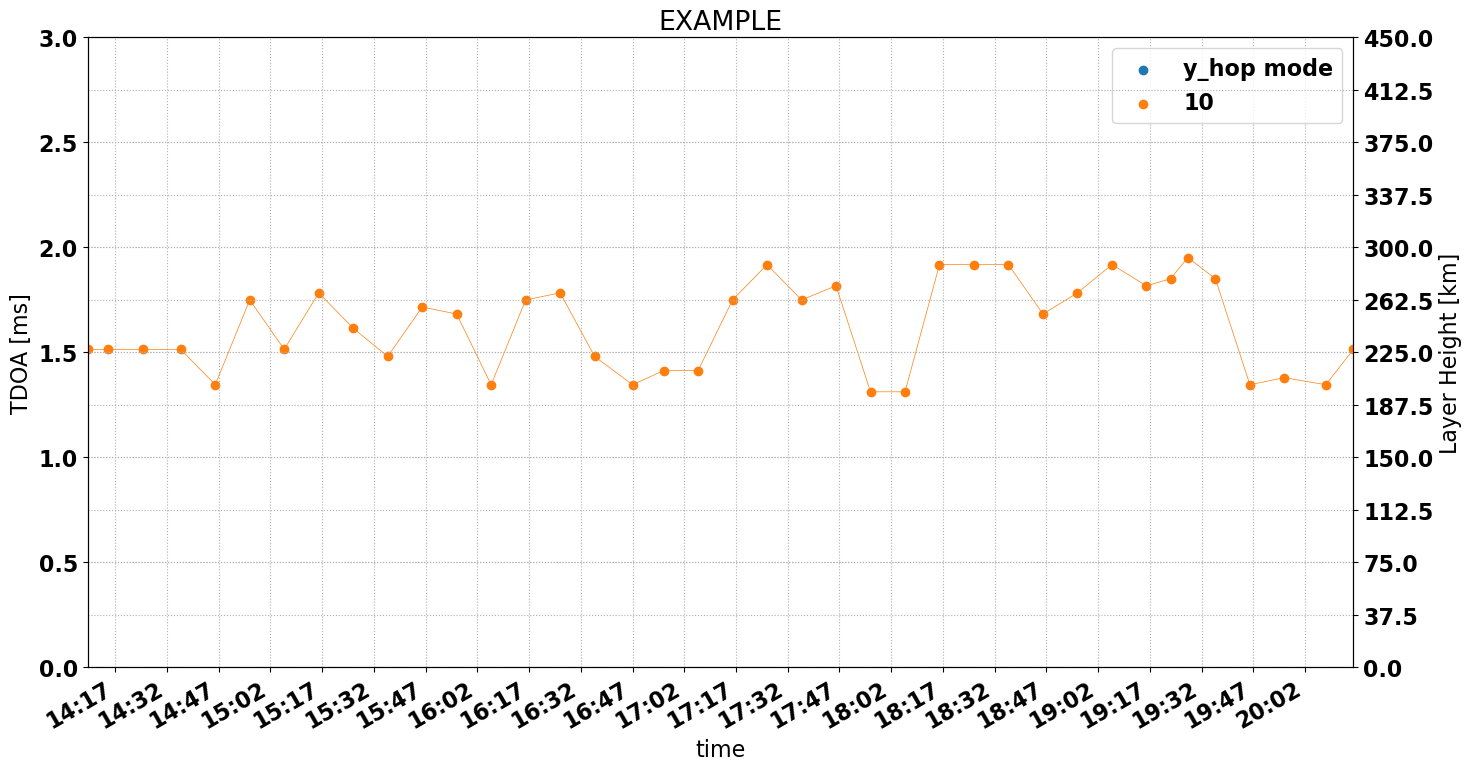

(array([1.51405334, 1.51405334, 1.51405334, 1.51405334, 1.3458252 ,
        1.74957275, 1.51405334, 1.78321838, 1.61499023, 1.48040771,
        1.71592712, 1.68228149, 1.3458252 , 1.74957275, 1.78321838,
        1.48040771, 1.3458252 , 1.41311646, 1.41311646, 1.74957275,
        1.9178009 , 1.74957275, 1.81686401, 1.31217957, 1.31217957,
        1.9178009 , 1.9178009 , 1.9178009 , 1.68228149, 1.78321838,
        1.9178009 , 1.81686401, 1.85050964, 1.95144653, 1.85050964,
        1.3458252 , 1.37947083, 1.3458252 , 1.51405334]),
 None)

In [22]:
# TDOAs_20m,avs20m = post_processing(beats_20m,"20m Band",times= twentyBand_times,plot_TDOAs=True)
# TDOAs_40m, avs40m = post_processing(beats_40m,"TX WA5FRF - RX N5DUP (317km) 7.2 MHz",times= fortyBand_times,plot_TDOAs=True,manual_TDOAs = ManuallyDecodedN5DUP40m, obscuration_times = eclipse_times, obscuration_values=obsc_N5, correlated_TDOAS= AutoCorrelatedN5DUP40m, solar_val = solarN5, lat = lat_N5, lon = lon_N5)

# TDOAs_60m,avs60m = post_processing(beats_60m,"N5DUP 60m Band",times= sixtyBand_times,plot_TDOAs=True, obscuration_times = times, obscuration_values=obsc)
# # # TDOAs_W3USR,avsUSR = post_processing(beats_W3USR,"w3USR Band",times= scrantonBand_times,plot_TDOAs=True)

# TDOAS_Sam40, avs40sam = post_processing(beats_40mSam,"TX WA5FRF - RX AB5YO (8.77km) 7.2 MHz",times= fortymSamBand_times,plot_TDOAs=True,manual_TDOAs = ManuallyDecodedAB5YO40m,obscuration_times = eclipse_times, obscuration_values=obsc_AB, correlated_TDOAS = AutoCorrelatedAB5YO40m, solar_val = solarAB, lat = lat_AB, lon = lon_AB)

# TDOAS_Sam60, avs60sam = post_processing(beats_60mSam,"TX WA5FRF - RX AB5YO (8.77km) 5.3 MHz",times= sixtymSamBand_times,plot_TDOAs=True,manual_TDOAs=ManuallyDecodedAB5YO60m, obscuration_times = eclipse_times, obscuration_values=obsc_AB, correlated_TDOAS= AutoCorrelatedAB5YO60m, solar_val = solarAB, lat = lat_AB, lon = lon_AB)

# post_processing(beats_20m,"TX = GOOFY MFS", twentyBand_times, plot_TDOAs= True)

post_processing(beats_60mSam, "EXAMPLE", sixtymSamBand_times, plot_TDOAs = True)


## Obscuration vs. Time

NameError: name 'avs40sam' is not defined

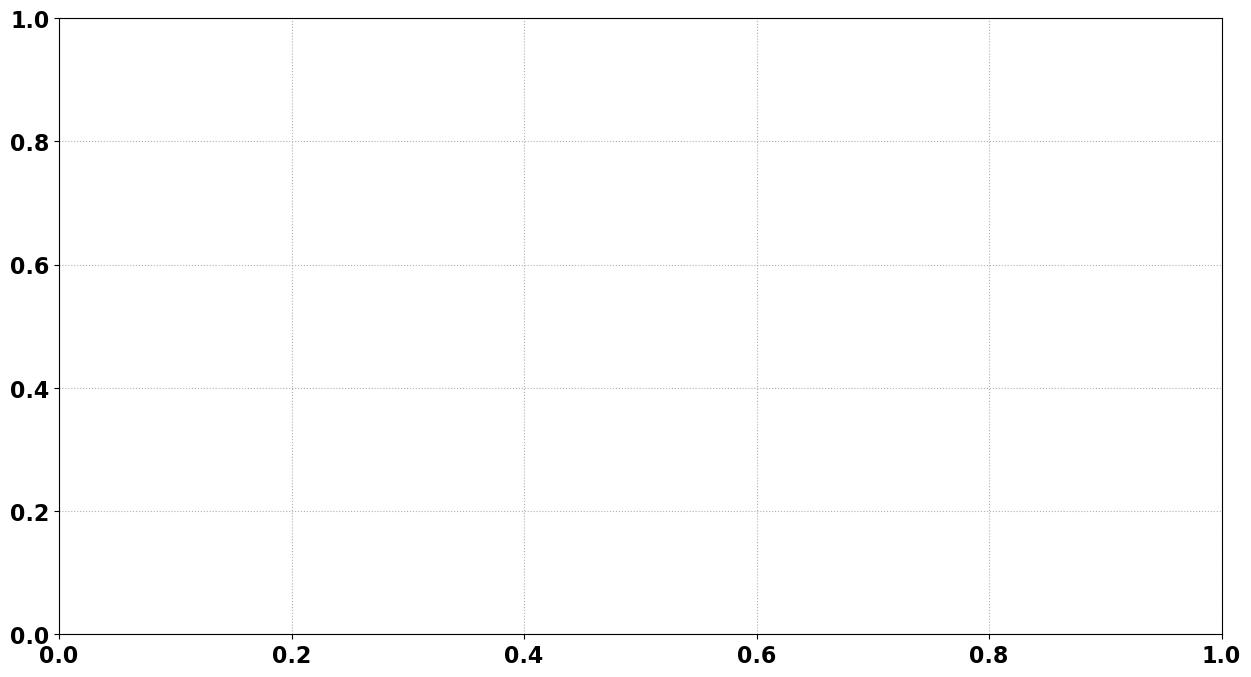

In [23]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1)

ax.plot(fortymSamBand_times, avs40sam, label='$7.2 MHz$')
ax.plot(sixtymSamBand_times, avs60sam, label='$5.3 MHz$')

#imipraimine

ymin = 1
ymax = 2.5
ax.set_ylim(ymin,ymax)
ax.set_xlim(datetime(2024,4,8,13,30),datetime(2024,4, 8, 22, 00))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))

ax2 = ax.twinx()
newlabels = np.arange(ymin,ymax+.01,.25)
ax2.set_yticks(np.arange(0,len(newlabels)))
ax2.set_yticklabels((300/2)*newlabels)
ax2.set_ylabel('Layer Height [km]')

ax.set_ylabel('TDOA [ms]')
ax.set_xlabel('Time [UTC]')
ax.legend()
# ax.set_title()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
plt.close(fig)